In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import skew, kurtosis
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
from imblearn.metrics import specificity_score



Dane

In [3]:
data = pd.read_csv('data/winequality-white.csv', delimiter=';')

In [4]:
types_temp = [i % 2 for i in range(len(data))]
data['type'] = types_temp

In [5]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0


OPIS I WSTEPNA ANALIZA DANYCH

Typy danych w zbiorze

In [6]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                      int64
dtype: object

Rozmiar danych

In [7]:
data.shape

(4898, 13)

Statystyki opisowe dla zmiennych liczbowych

In [8]:
data_float_column = data.select_dtypes(include=[float]).columns
data[data_float_column].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


Analiza Wpływu Zmiennych na Zmienną Prognozowaną (Y)


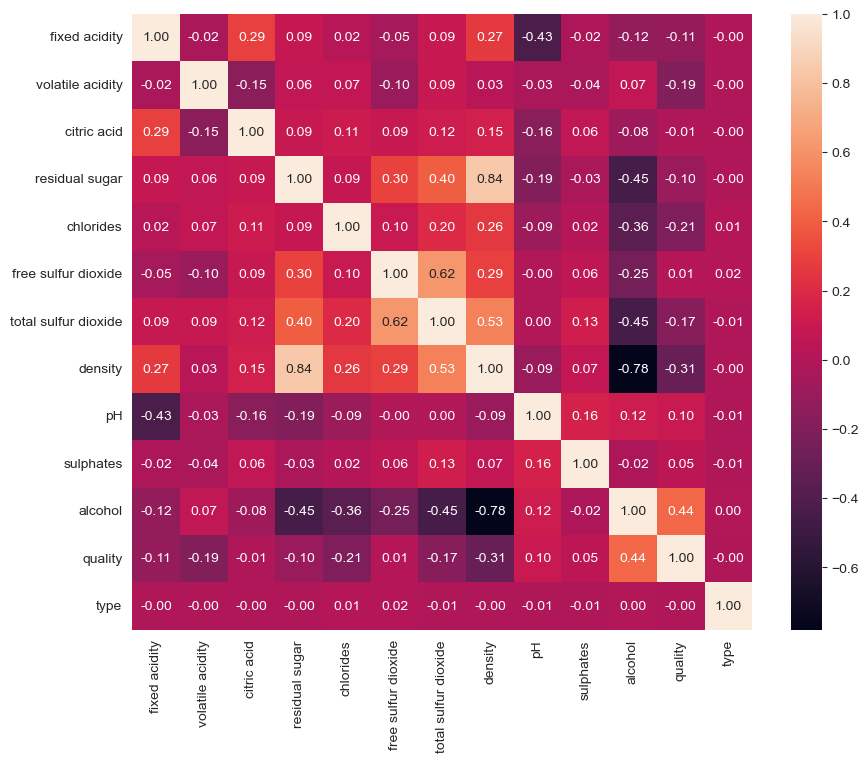

In [9]:
#heat mapa korelacji  ale nie wiem czy to dobra metoda
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.show()

In [10]:
# Przypuśćmy, że 'df' to twój DataFrame, a 'quality' to twoja zmienna binarna.
# Przeiteruj przez wszystkie kolumny (oprócz 'quality') i oblicz korelację punktowo-biserialną.
for column in data.columns.drop('quality'):
    pbc = pointbiserialr(data[column], data['quality'])
    print(f"Korelacja punktowo-biserialna między {column} a quality: {pbc.correlation:.3f}, p-wartość: {pbc.pvalue:.4f}")


Korelacja punktowo-biserialna między fixed acidity a quality: -0.114, p-wartość: 0.0000
Korelacja punktowo-biserialna między volatile acidity a quality: -0.195, p-wartość: 0.0000
Korelacja punktowo-biserialna między citric acid a quality: -0.009, p-wartość: 0.5193
Korelacja punktowo-biserialna między residual sugar a quality: -0.098, p-wartość: 0.0000
Korelacja punktowo-biserialna między chlorides a quality: -0.210, p-wartość: 0.0000
Korelacja punktowo-biserialna między free sulfur dioxide a quality: 0.008, p-wartość: 0.5681
Korelacja punktowo-biserialna między total sulfur dioxide a quality: -0.175, p-wartość: 0.0000
Korelacja punktowo-biserialna między density a quality: -0.307, p-wartość: 0.0000
Korelacja punktowo-biserialna między pH a quality: 0.099, p-wartość: 0.0000
Korelacja punktowo-biserialna między sulphates a quality: 0.054, p-wartość: 0.0002
Korelacja punktowo-biserialna między alcohol a quality: 0.436, p-wartość: 0.0000
Korelacja punktowo-biserialna między type a quality:

Ocena zbalansowania zbioru danych

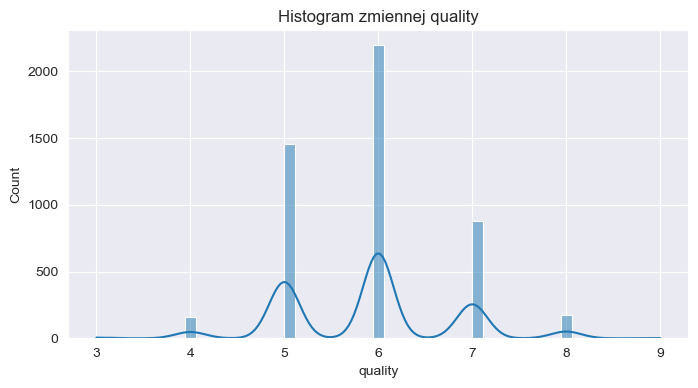

In [11]:
#Histogram
plt.figure(figsize=(8,4))
sns.histplot(data['quality'], kde=True)
plt.title('Histogram zmiennej quality')
plt.show()

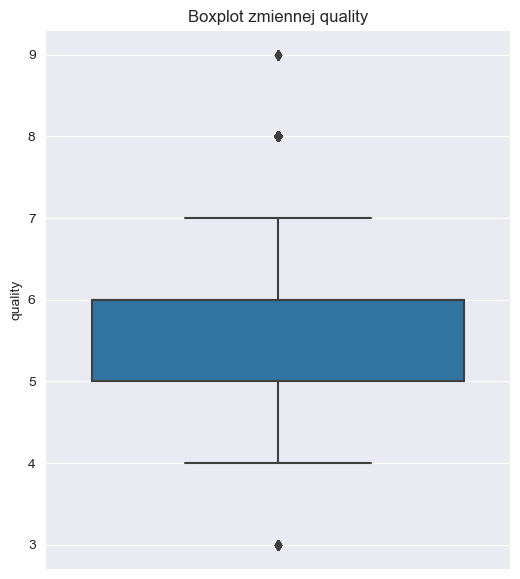

In [12]:
#Boxplot
plt.figure(figsize=(6, 7))
sns.boxplot(y=data['quality'])
plt.title('Boxplot zmiennej quality')
plt.show()

In [13]:
#Skośnosc i kurtoza
print(f"Skośność: ", skew(data['quality']))
print(f'Kurtoza: ', kurtosis(data['quality']))

Skośność:  0.15574868141362455
Kurtoza:  0.21508011570192975


PRZYGOTOWANIE DANYCH

Wartosci brakujace

In [14]:
data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

Sprawdzenie wartosci odstajacych

In [15]:
# fig, axs = plt.subplots(ncols=3, nrows = 3, figsize=(15,15))
# 
# sns.boxplot(ax=axs[0][0], y=data['fixed acidity'])
# axs[0][0].set_title('fixed acidity')
# 
# sns.boxplot(ax=axs[1], y=data['volatile acidity'])
# axs[1].set_title('volatile acidity')
# 
# sns.boxplot(ax=axs[2], y=data['citric acid'])
# axs[2].set_title('citric acid')
# 
# sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
# plt.tight_layout()
# plt.show()

PODZIAL DANYCH NA ZBIOR UCZACY I TESTOWY


In [27]:
X = data.drop('quality', axis=1)
y = data['quality']

In [28]:
#podzial na zbior testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
#kopia danych
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

Statystyki opisowe dla zbiorow

In [30]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000
mean,6.865046,0.279338,0.332731,6.450702,0.045734,35.094564,138.001149,0.994071,3.189293,0.489781,10.508840,0.498469
std,0.844483,0.101606,0.119758,5.139311,0.021797,16.676958,42.067667,0.003022,0.150183,0.113590,1.227887,0.500061
min,3.800000,0.080000,0.000000,0.600000,0.009000,3.000000,10.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991740,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,33.000000,134.000000,0.993800,3.180000,0.470000,10.400000,0.000000
75%,7.300000,0.330000,0.380000,10.000000,0.050000,46.000000,167.000000,0.996200,3.280000,0.550000,11.400000,1.000000
max,11.800000,1.100000,1.660000,65.800000,0.346000,146.500000,313.000000,1.038980,3.820000,1.080000,14.200000,1.000000


In [31]:
X_test.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,6.813776,0.273857,0.340031,6.154388,0.045926,36.161735,139.797959,0.993854,3.184163,0.490112,10.535963,0.506122
std,0.840584,0.097411,0.125833,4.788953,0.022059,18.251705,44.169785,0.002859,0.154235,0.116302,1.241884,0.500218
min,3.900000,0.080000,0.000000,0.700000,0.014000,2.000000,9.000000,0.987220,2.800000,0.250000,8.000000,0.000000
25%,6.200000,0.210000,0.270000,1.700000,0.036000,24.000000,110.000000,0.991650,3.080000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.000000,0.042000,34.500000,134.000000,0.993655,3.170000,0.480000,10.400000,1.000000
75%,7.300000,0.320000,0.390000,9.325000,0.050000,46.250000,168.000000,0.995970,3.270000,0.550000,11.400000,1.000000
max,14.200000,0.760000,0.990000,22.600000,0.240000,289.000000,440.000000,1.001000,3.800000,1.010000,14.000000,1.000000


ALGORYTM SVM

Standaryzacja zmiennych

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
def svm_algorithm(kernel):
    model = svm.SVC(kernel=kernel)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train,  average=None)
    recall_test = recall_score(y_test, y_pred_test, average=None)
    specificity_train = specificity_score(y_train, y_pred_train)
    specificity_test = specificity_score(y_test, y_pred_test)

    measures = ['', 'Dokładność', 'Czułość', 'Specyficzność']    
    print(f'Jądro: {kernel}')
    print(f'{measures[0]: <10} {measures[1]: <15} {measures[2]: <20} {measures[3]: <25}')
    print(f'Treningowy {round(accuracy_train, 3): <15} {round(recall_train, 3): <20} {round(specificity_train, 3): <25}')
    print(f'Testowy    {round(accuracy_test, 3): <15} {round(recall_test, 3): <20} {round(specificity_test, 3): <25}')
    print()

    
    

In [42]:
svm_algorithm('rbf')

ValueError: Target is multiclass but average='binary'. Please choose another average setting.